In [1]:
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz, colorea_minimo_fila

In [2]:
%%capture
%mkdir -p ~/temp
%cd ~/temp

# Enunciado
Considere la información del proyecto cuya información aparece en la tabla adjunta:

In [3]:
periodo_probabilidad_b = 9
pregunta_1 = f"1. ¿Cuál es la probabilidad de terminar el proyecto antes de {periodo_probabilidad_b} periodos?  "
pregunta_2 = "2. Indique las actuaciones a llevar a cabo para reducir la duración del proyecto hasta 10 periodos con mínimo sobrecoste.  "
pregunta_3 = "3. Nivele los recursos del proyecto.  "

In [4]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))

1. ¿Cuál es la probabilidad de terminar el proyecto antes de 9 periodos?  

2. Indique las actuaciones a llevar a cabo para reducir la duración del proyecto hasta 10 periodos con mínimo sobrecoste.  

3. Nivele los recursos del proyecto.  

In [5]:
# Alargamos el ancho de las celdas
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, desviacion,  cur,  recursos, duracion_tope
     ('A',       '---  ',     3,        2,          5,       1,        1      ),
     ('B',       '---  ',     2,        1,          5,       1,        1      ),
     ('C',       'B    ',     4,        2,         25,       1,        2      ),
     ('D',       'A    ',     4,        0,          1,       1,        1      ),
     ('E',       'A    ',     2,        1,        -10,       2,        1      ),
     ('F',       'C,D  ',     5,        3,          1,       1,        2      ),
     ('G',       'C,D  ',     1,        0,        -20,       2,        1      ),
     ('H',       'E    ',     3,        1,          5,       1,        2      ),
     ('I',       'F,G  ',     1,        0,          5,       2,        1      ),
     ('J',       'F,G  ',     2,        0,         -1,       1,        1      ),
     ('K',       'F,G,H',     1,        0,          1,       1,        1      ),
] ,columns=['activity', 'predecessor', 'duration', 'standard_deviation', 'ucr', 'resources', 'cap_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,standard_deviation,ucr,resources,cap_duration
activity,,,,,,
A,---,3,2,5,1,1
B,---,2,1,5,1,1
C,B,4,2,25,1,2
D,A,4,0,1,1,1
E,A,2,1,-10,2,1
F,"C,D",5,3,1,1,2
G,"C,D",1,0,-20,2,1
H,E,3,1,5,1,2
I,"F,G",1,0,5,2,1


# Solución
## Apartado 1

In [6]:
display(Markdown(pregunta_1))

1. ¿Cuál es la probabilidad de terminar el proyecto antes de 9 periodos?  

### Cuadro de prelaciones expandido

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [7]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
datos_proyecto=datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K
activities,,,,,,,,,,,
A,,,,,,,,,,,
B,,,,,,,,,,,
C,,True,,,,,,,,,
D,True,,,,,,,,,,
E,True,,,,,,,,,,
F,,,True,True,,,,,,,
G,,,True,True,,,,,,,
H,,,,,True,,,,,,
I,,,,,,True,True,,,,


In [8]:
proyecto = prelaciones.create_project()

### Grafo PERT con numeración de nodos

Utilizando el cuadro de prelaciones expandido podemos dibujar el grafo Pert correspondiente al proyecto.

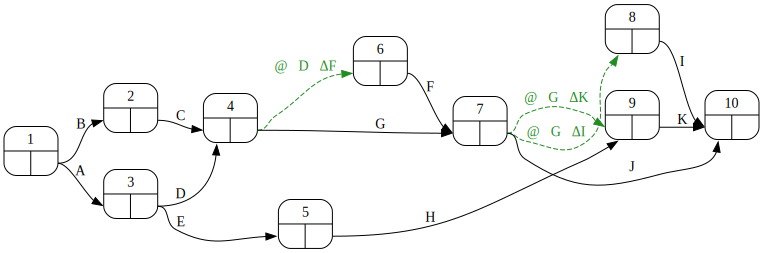

In [9]:
#| fig-cap: "Grafo Pert con indicación con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto.pert()

Alternativamente podríamos haber representado su grafo Roy.

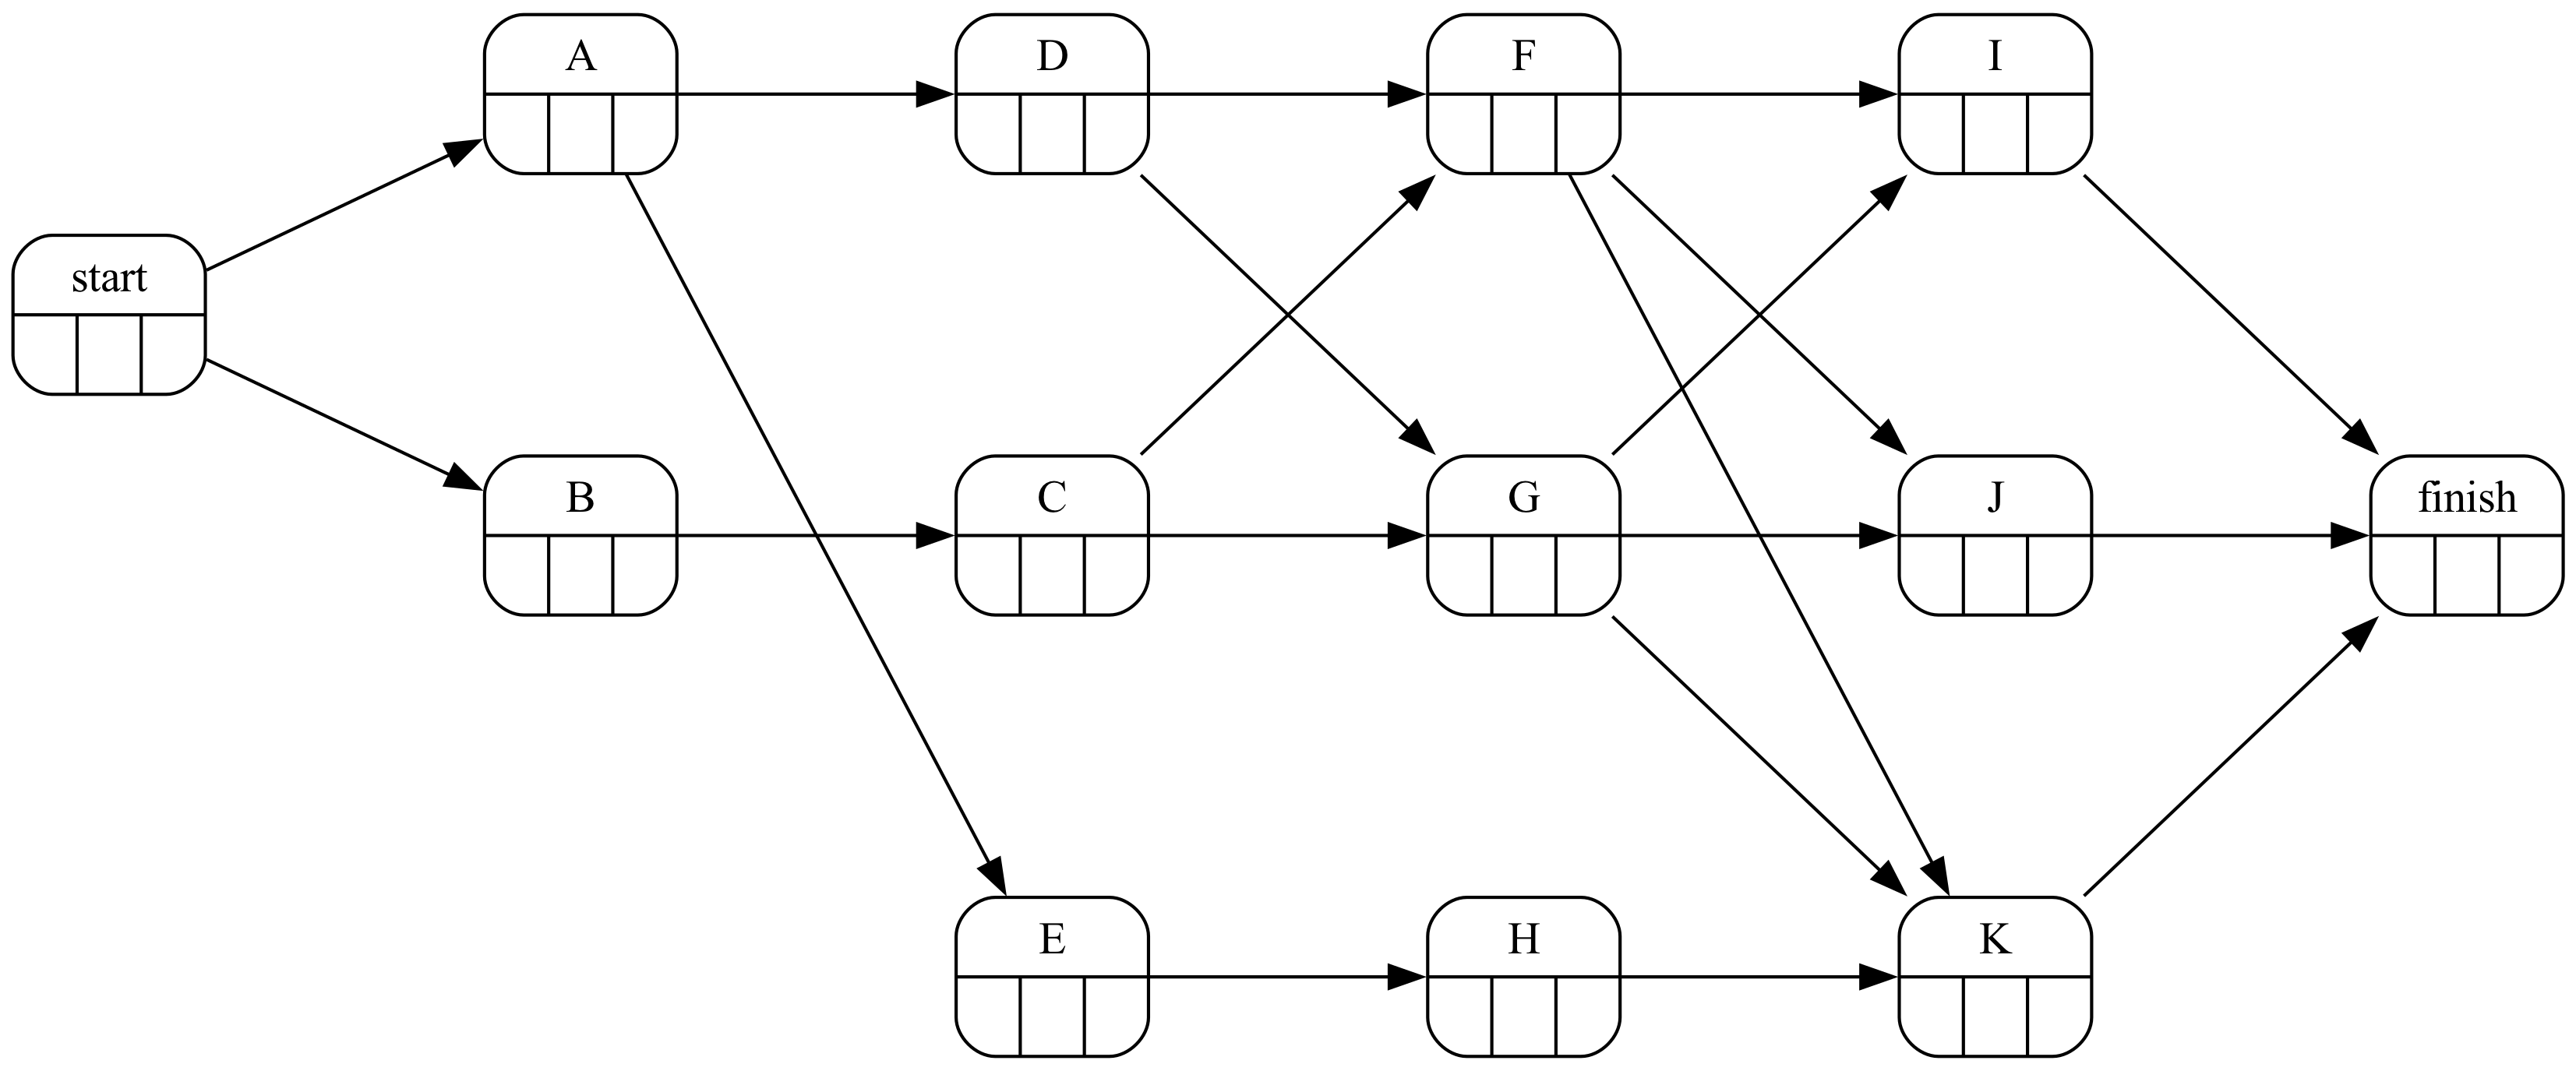

In [10]:
#| fig-cap: "Grafo Roy del proyecto"
#| label: fig-roy
proyecto.roy(ranksep=1.2, nodesep=1.2)

### Matriz de Zaderenko

A continuación podemos determinar la duración del proyecto calculando los tiempos tempranos y tardíos de su grafo Pert. Se hace en este caso mediante el algoritmo de Zaderenko:

In [11]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,early
1,,2.0,3.0,,,,,,,,0.0
2,,,,4.0,,,,,,,2.0
3,,,,4.0,2.0,,,,,,3.0
4,,,,,,0.0,1.0,,,,7.0
5,,,,,,,,,3.0,,5.0
6,,,,,,,5.0,,,,7.0
7,,,,,,,,0.0,0.0,2.0,12.0
8,,,,,,,,,,1.0,12.0
9,,,,,,,,,,1.0,12.0
10,,,,,,,,,,,14.0


Los tiempos tempranos y tardíos obtenidos para cada nodo son:

In [12]:
#| tbl-cap: "Valores de los tiempos tempranos y tardíos de los nodos"
#| label: tbl-TempranosTardios
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,2,3
3,3,3
4,7,7
5,5,10
6,7,7
7,12,12
8,12,13
9,12,13
10,14,14


### Duración media del proyecto

In [13]:
duracion_media_proyecto = int(float(proyecto.duration(datos_proyecto['duration'])))

In [14]:
Markdown(f"De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es {duracion_media_proyecto} periodos.")

De acuerdo a la duración obtenida para el nodo final del proyecto, la duración media del proyecto es 14 periodos.

### Calendario del proyecto
Las fechas de inicio y fin más tempranas y tardías de cada actividad son:

In [15]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
calendario = proyecto.calendar(datos_proyecto['duration'])
calendario

,inicio_mas_temprano,inicio_mas_tardio,fin_mas_temprano,fin_mas_tardio,H_total,duracion
activity,,,,,,
A,0,0,3,3,0,3
B,0,1,2,3,1,2
C,2,3,6,7,1,4
D,3,3,7,7,0,4
E,3,8,5,10,5,2
F,7,7,12,12,0,5
G,7,11,8,12,4,1
H,5,10,8,13,5,3
I,12,13,13,14,1,1


### Varianza de la duración del proyecto
Para determinar la varianza del proyecto es necesario conocer la varianza de cada una de las rutas del camino crítico. Es necesario, por tanto, conocer cuales son las actividades con holgura total cero.

#### Holgura total de las actividades
Del cálculo de las holguras totales obtenemos:

In [16]:
#| tbl-cap: "Holgura total de las actividades"
#| label: tbl-holguras
resultados_pert['activities'][['H_total']]

,H_total
@∇D⤑ΔF,0
@∇G⤑ΔI,1
@∇G⤑ΔK,1
A,0
B,1
C,1
D,0
E,5
F,0
G,4


#### Camino crítico
Las actividades con holgura total cero forman el camino crítico. Según el grafo Pert del proyecto, éste está compuesto por las siguientes rutas, cuyas actividades se listan en orden alfabético:

In [17]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
for ruta, actividades in camino_critico.items():
    display(Markdown(f"{ruta}: " + ", ".join(actividades)))

Route_2: A, D, F, J

#### Grafo PERT con indicación del camino crítico

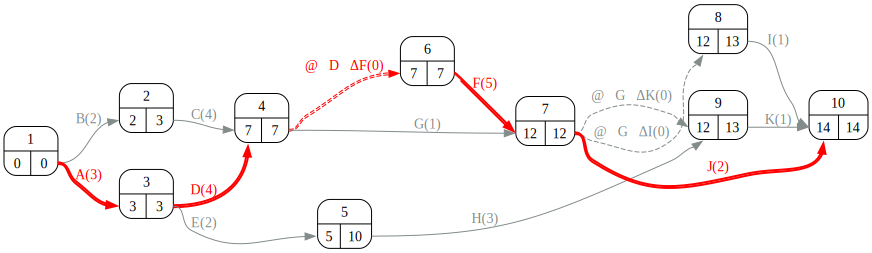

In [18]:
#| fig-cap: "Grafo Pert del proyecto con indicación del camino crítico"
#| label: fig-pertCritico
proyecto.pert(durations=datos_proyecto['duration'])

Alternativamente, se muestra el grafo roy correspondiente con indicación del camino crítico.

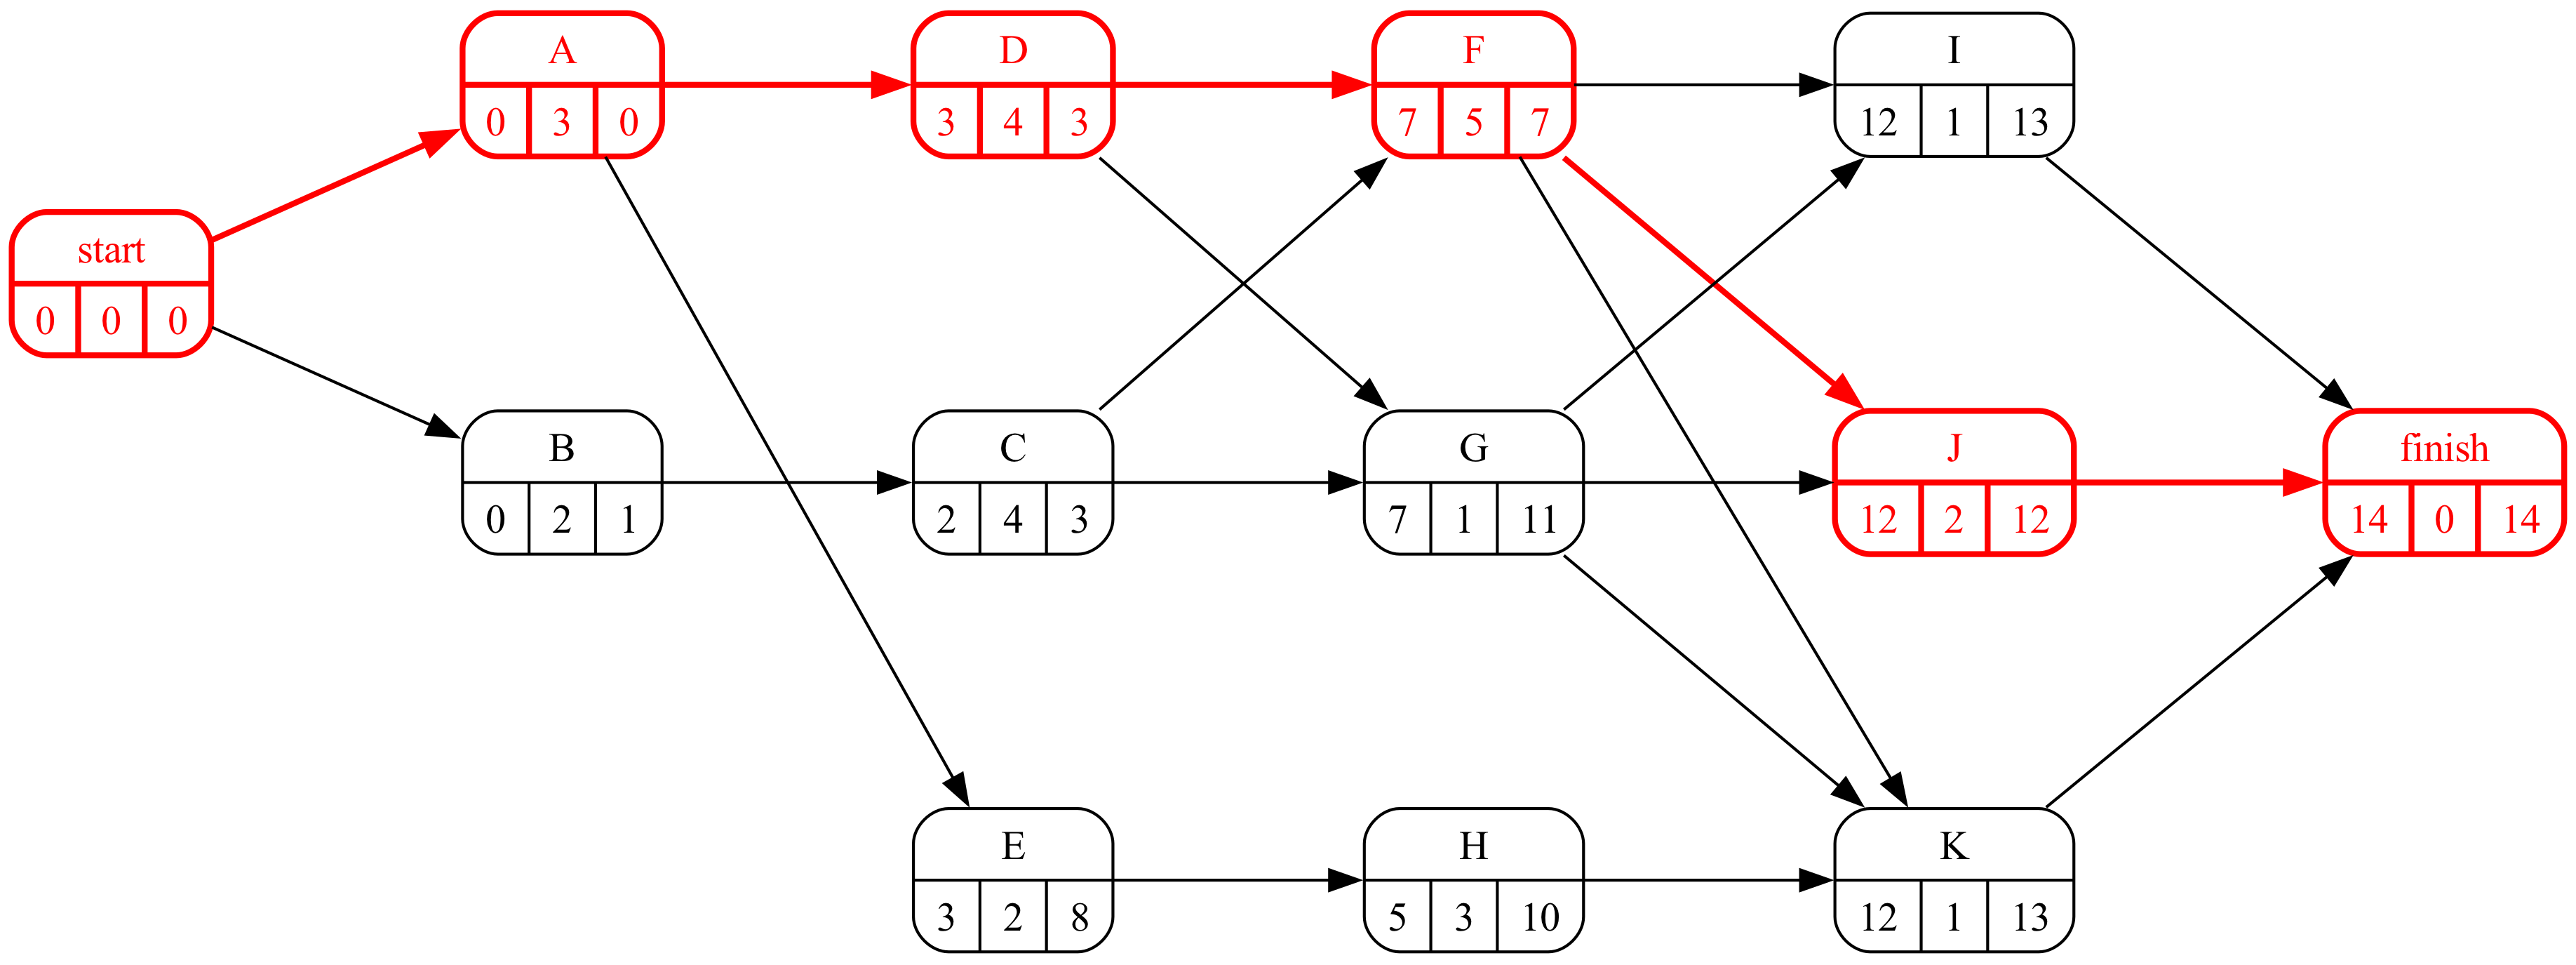

In [19]:
#| fig-cap: "Grafo Roy del proyecto con indicación del camino crítico"
#| label: fig-royCritico
proyecto.roy(durations=datos_proyecto['duration'], ranksep=1.2, nodesep=1.2)

#### Varianza de cada rama

Se calcula entonces la varianza de cada una de las rutas del camino crítico como suma de las varianzas de las actividades que lo componen.

El enunciado nos aporta la desviación típica, la varianza se calcula elevando al cuadrado.

In [20]:
desviacion_proyecto, varianza_caminos = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto.eval('standard_deviation ** 2'))

In [21]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas
varianza_caminos

,Activities,Variance
Route_2,"A, D, F, J",13.00


In [22]:
display(Markdown(f"""La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es {round(desviacion_proyecto**2,2)}.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  """))
display(Markdown(f"La desviación típica es {round(desviacion_proyecto,2)}"""))


La varianza de la duración del proyecto es la máxima varianza de las rutas críticas. Para este proyecto es 13.0.  
Habitualmente será útil calcular su raiz cuadrada, la desviación típica, para ser utilizada como parámetro de la ley de distribución normal.  

La desviación típica es 3.61

### Probabilidad de terminar antes de 9 periodos

In [23]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = round(float(norm.cdf(periodo_probabilidad_b, loc=duracion_media_proyecto, scale=desviacion_proyecto)), 2)

Markdown(f"Para un proyecto con duración media {duracion_media_proyecto} y desviación típica {round(desviacion_proyecto, 2)} el valor de la probabilidad de terminar antes de {periodo_probabilidad_b} periodos es {round(probabilidad_de_terminar_antes_de_b * 100, 2)} por ciento.")

Para un proyecto con duración media 14 y desviación típica 3.61 el valor de la probabilidad de terminar antes de 9 periodos es 8.0 por ciento.

## Apartado 2

In [24]:
display(Markdown(pregunta_2))

2. Indique las actuaciones a llevar a cabo para reducir la duración del proyecto hasta 10 periodos con mínimo sobrecoste.  

In [25]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['cap_duration'],
                costs=datos_proyecto['ucr'],
                report=False,
                reduction=4)

In [26]:
#| tbl-cap: "Cuadro del algoritmo de Ackoff Sasieni"
#| label: tbl-ackoff
ackoff

,A,B,C,D,E,F,G,H,I,J,K,0,1,2,3,4
Route_1,5.0,,,1.0,,1.0,,,5.0,,,13.0,13.0,12.0,11.0,10.0
Route_2,5.0,,,1.0,,1.0,,,,-1.0,,14.0,13.0,12.0,11.0,10.0
Route_3,5.0,,,1.0,,1.0,,,,,1.0,13.0,13.0,12.0,11.0,10.0
Route_4,5.0,,,1.0,,,-20.0,,5.0,,,9.0,9.0,8.0,8.0,8.0
Route_5,5.0,,,1.0,,,-20.0,,,-1.0,,10.0,9.0,8.0,8.0,8.0
Route_6,5.0,,,1.0,,,-20.0,,,,1.0,9.0,9.0,8.0,8.0,8.0
Route_7,5.0,,,,-10.0,,,5.0,,,1.0,9.0,9.0,9.0,9.0,9.0
Route_8,,5.0,25.0,,,1.0,,,5.0,,,12.0,12.0,12.0,11.0,10.0
Route_9,,5.0,25.0,,,1.0,,,,-1.0,,13.0,12.0,12.0,11.0,10.0
Route_10,,5.0,25.0,,,1.0,,,,,1.0,12.0,12.0,12.0,11.0,10.0


In [27]:
for iteracion, actividades in best_option.items():
    display(Markdown(f"- Iteración {iteracion}: " + ", ".join(actividades) + "<br>"))

- Iteración 0: J<br>

- Iteración 1: D<br>

- Iteración 2: F<br>

- Iteración 3: F<br>

Tras esta reducción ya se ha alcanzado el objetivo de 10 periodos de duración.
Se muestra la representación Pert y Roy del proyecto con las nuevas duración y la indicación de los caminos críticos.

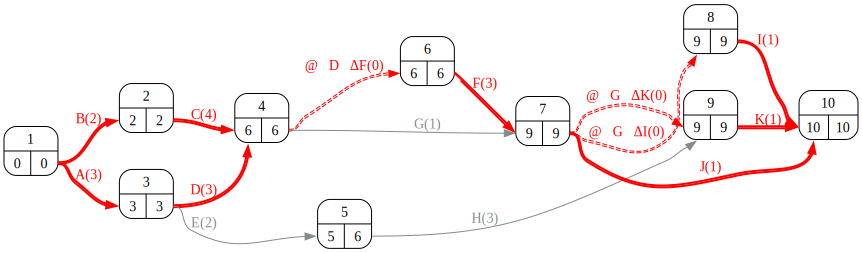

In [28]:
proyecto.pert(durations=duration)

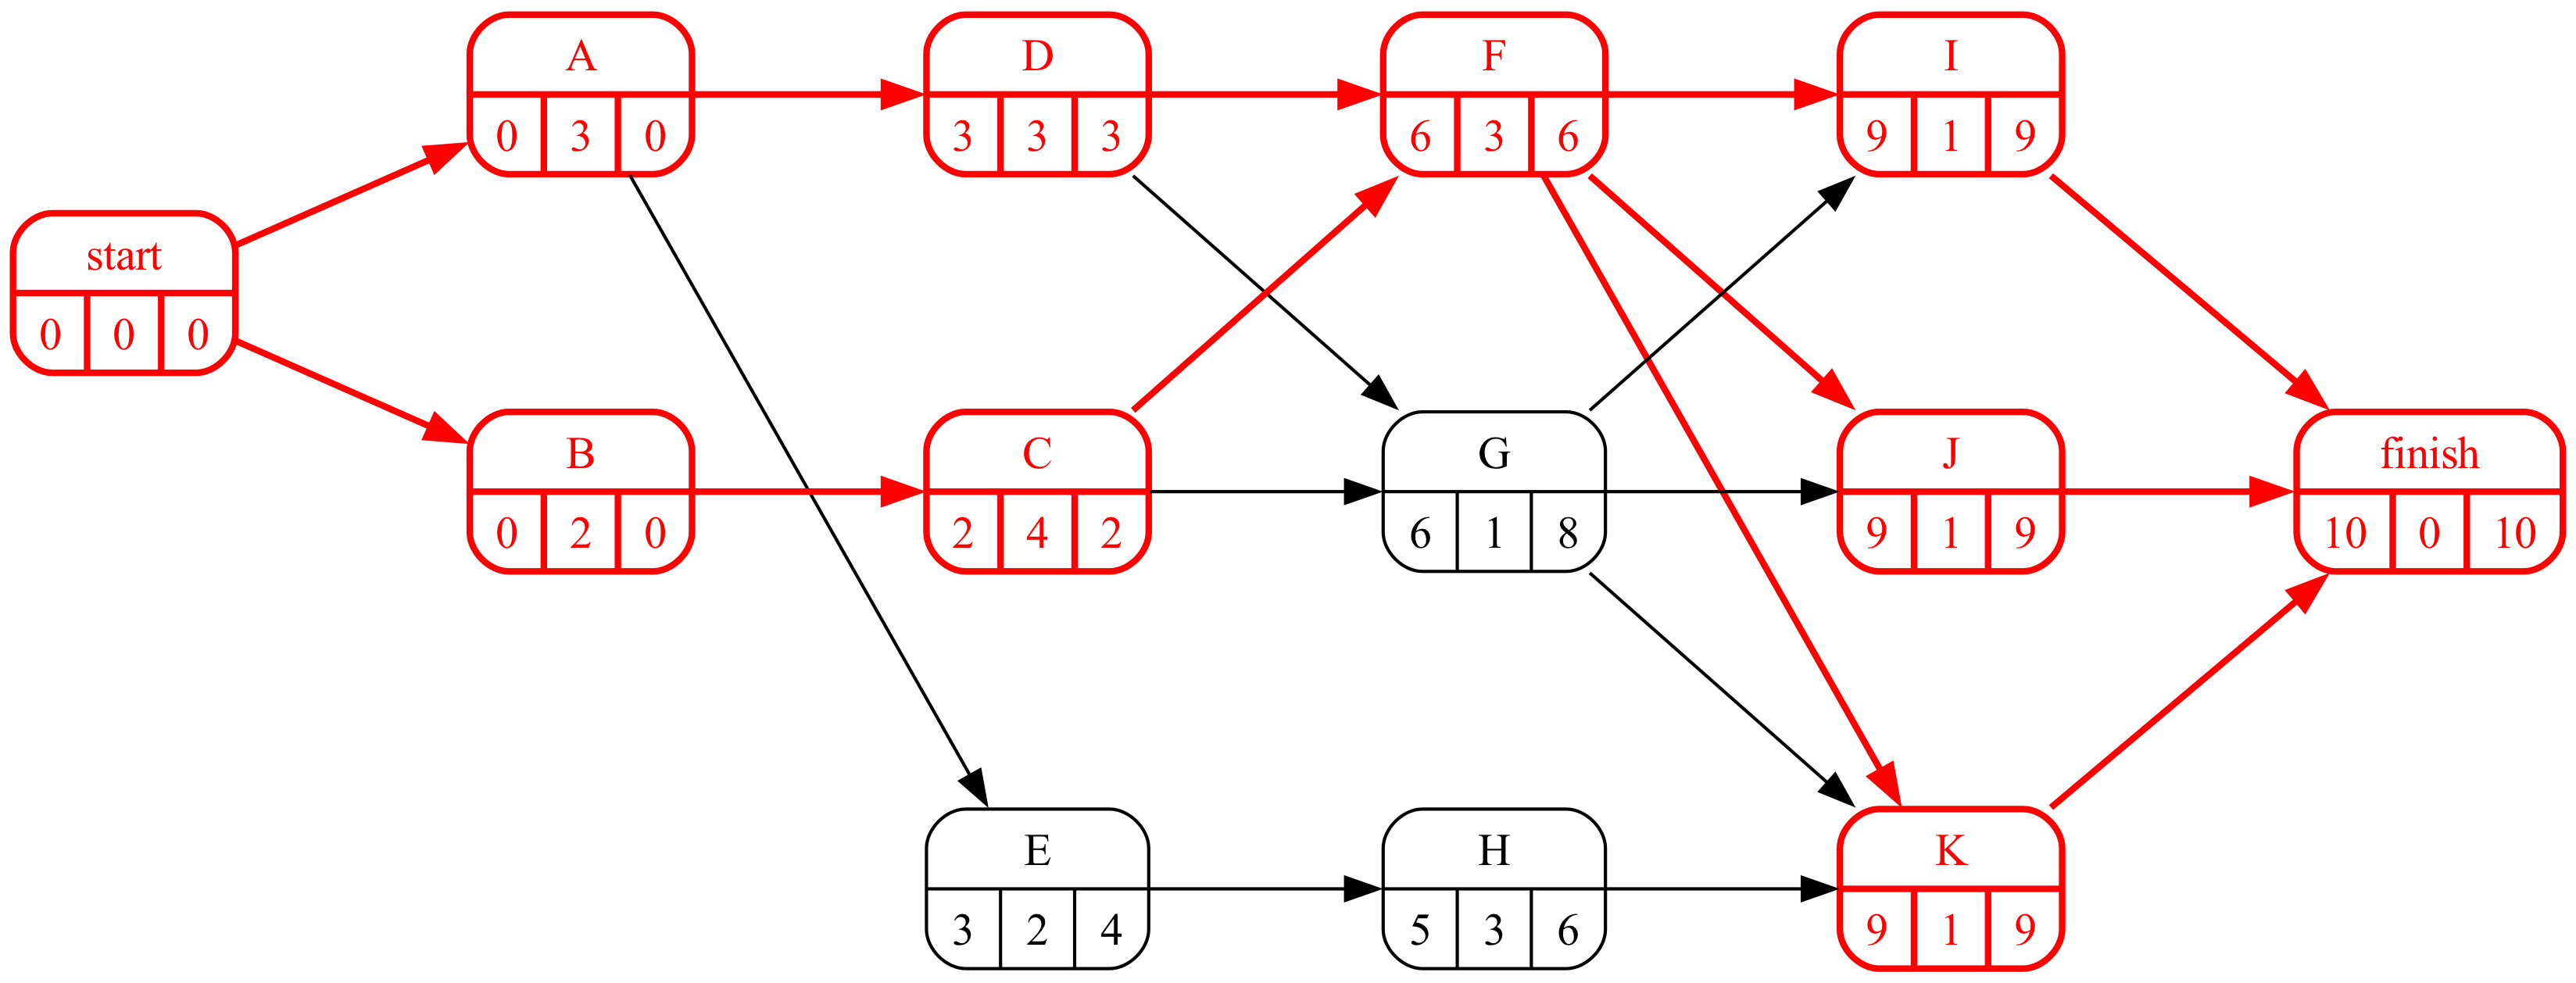

In [29]:
proyecto.roy(durations=duration, ranksep=1, nodesep=1)

## Apartado 3

In [30]:
display(Markdown(pregunta_3))

3. Nivele los recursos del proyecto.  

### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

Suma de cuadrados: 94 



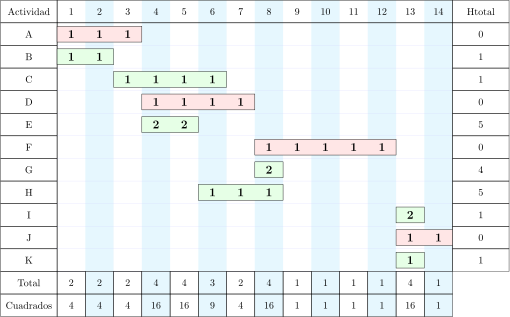

In [31]:
#| fig-cap: "Diagrama de Gantt del proyecto antes de la nivelación"
#| label: fig-ganttPrenivelacion
proyecto_nivelacion = proyecto.copy()
datos_proyecto = datos_enunciado.copy()

gantt_recursos, dibujo = proyecto_nivelacion.gantt_cargas(datos_proyecto, 'duration', 'resources', tikz=True)
pinta_tikz(dibujo)

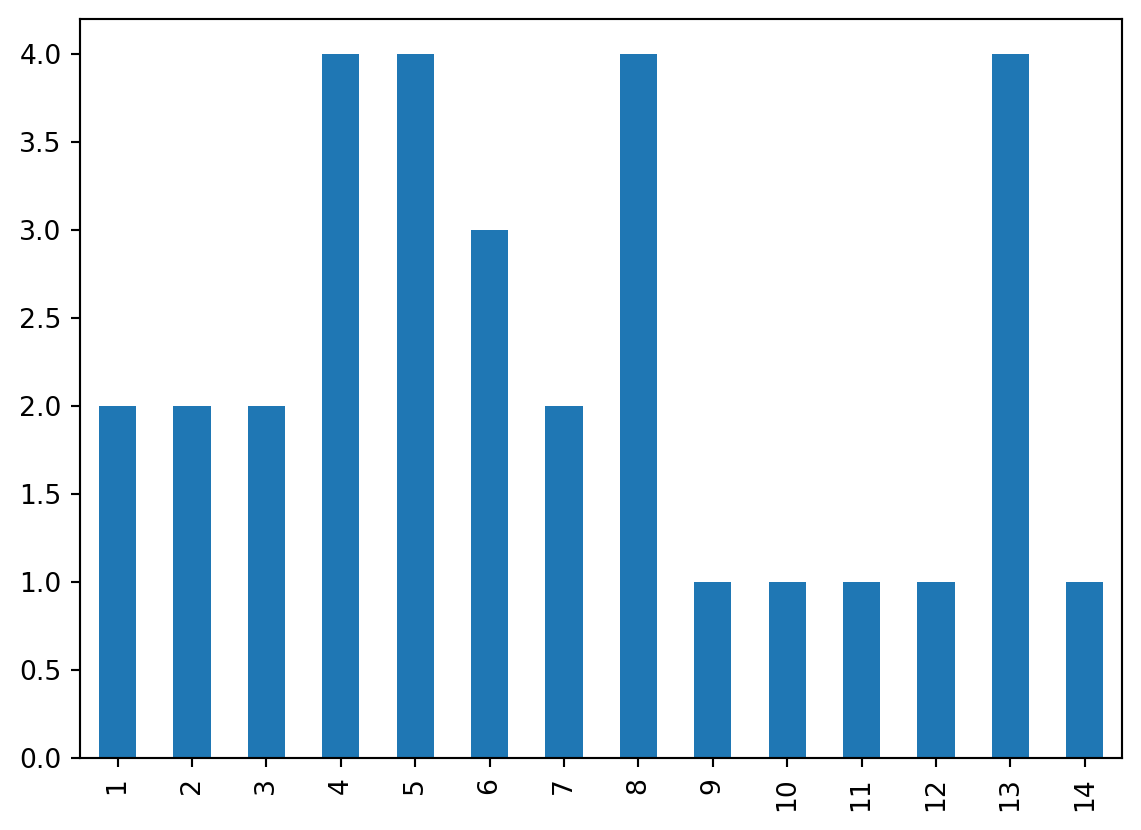

In [32]:
#| fig-cap: "Diagrama de cargas del proyecto antes de la nivelación"
#| label: fig-ganttPrenivelacionCargas
(gantt_recursos.data.loc['Total'].drop('H_total').plot(kind='bar'));

La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

### Orden de desplazamientos

Se aplican las siguientes reglas:  
   - Se desplazan primero aquellas no críticas aun no desplazadas con su final más temprano más próximo al principio del proyecto.  
   - En caso de empate se preferirá mover primero la de mayor holgura.  
   - De persistir el empate se moverá la de menor duración.  
   - Descartamos del análisis las actividades f1 y f2 por no consumir recursos.  
   - En caso de persistir el empate, resulta indiferente una u otra.  

In [33]:
desplazamientos, cuadrados, my_data, gantt_df, dibujo = proyecto_nivelacion.nivelar(
                            data=datos_proyecto,
                            duration_label='duration',
                            resource_label='resources',
                            
                           )

La siguiente tabla indica el valor de la suma de los cuadrados del consumo de los recursos para cada unos de los posibles desplazamientos, en el orden de desplazamiento de las actividades utilizado. El orden seguido ha sido el de las actividades no críticas en orden creciente de periodo de finalización. Se señala en color amarillo el desplazamiento que en cada caso minimiza la suma de cuadrados.

In [34]:
#| tbl-cap: "Suma de los cuadrados de las cargas para cada uno de los desplazamientos posibles con indicación del mínimo en cada actividad"
#| label: tbl-CuadradosNivelacion
cuadrados

,0,1,2,3,4,5
activity,,,,,,
B,94,96,,,,
E,94,92,88,88,88,80
C,80,80,,,,
H,80,,,,,
G,80,88,88,84,84,
I,80,80,,,,
K,80,,,,,


Atendiendo a los valores de las sumas de cuadrados, los desplazamientos indicados para la nivelación son:

In [35]:
#| tbl-cap: "Desplazamientos para la nivelación"
#| label: tbl-desplazamientosNivelación
desplazamientos

,desplazamientos
B,0
E,5
C,0
H,0
G,0
I,0
K,0


La planificación del proyecto nivelado se muestra en el siguiente diagrama de Gantt.

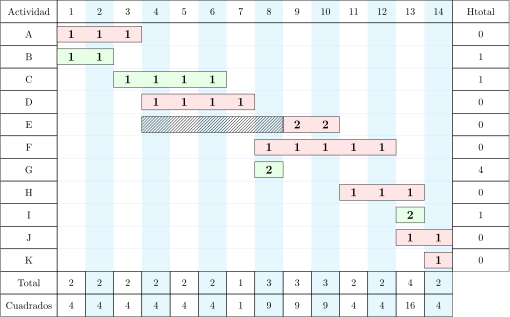

In [36]:
#| fig-cap: "Diagrama de Gantt del proyecto tras la nivelación"
#| label: fig-ganttPostnivelacion
pinta_tikz(dibujo)